In [182]:
import pandas as pd
from scipy import stats

In [183]:
df = pd.read_csv('./WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(df.shape)
df.head(3)

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [184]:
df['TotalCharges'] = df['TotalCharges'].str.split(' ').str[0]

In [185]:
df['TotalCharges'] = df['TotalCharges'].apply(pd.to_numeric)

In [196]:
print(df.shape)
df = df.dropna(axis = 0)
print(df.shape)

(7043, 21)
(7032, 21)


<AxesSubplot:xlabel='PaymentMethod', ylabel='TotalCharges'>

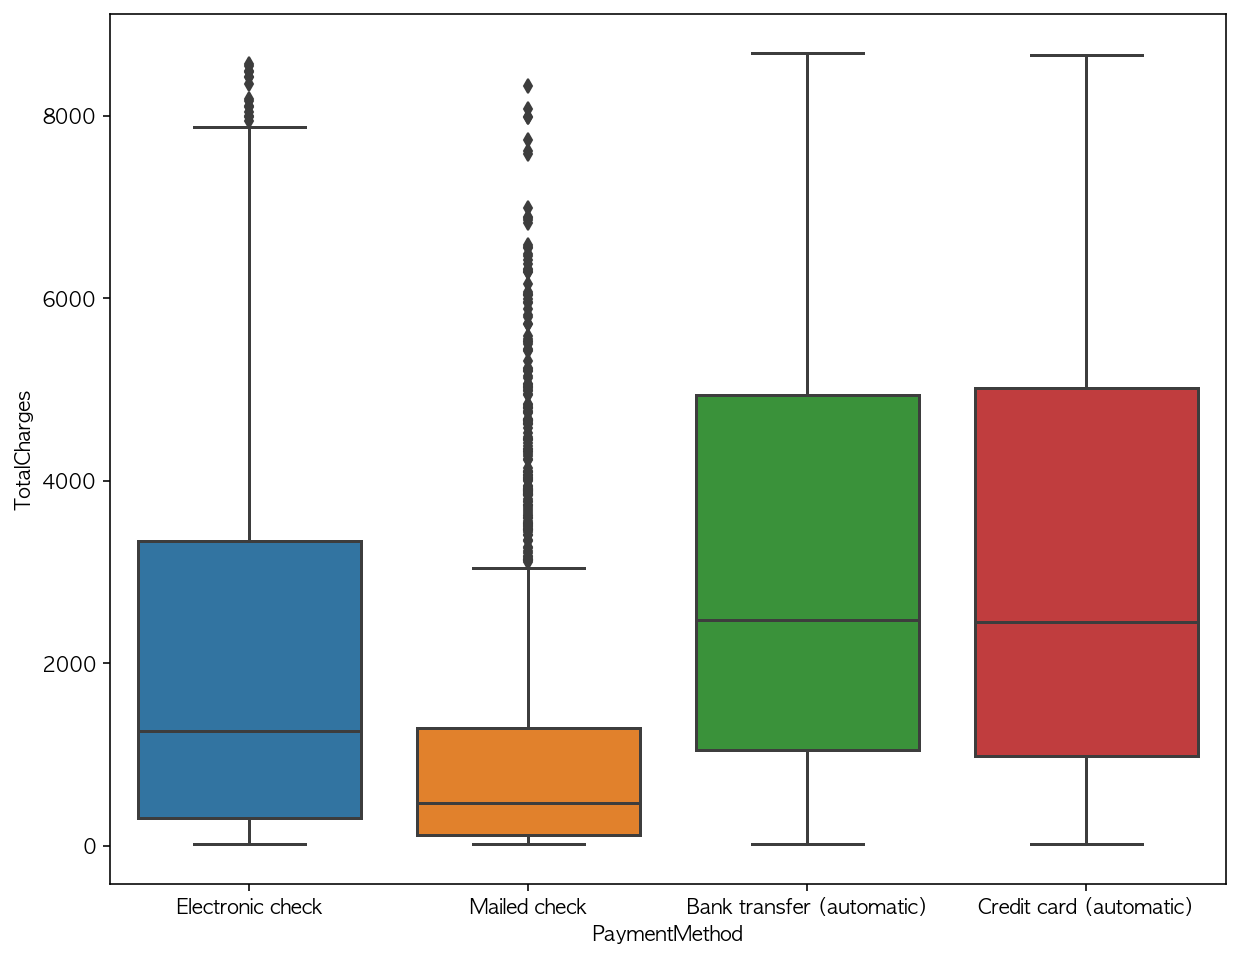

In [197]:
plt.figure(figsize = (10,8))
sns.boxplot(x = 'PaymentMethod' , y = 'TotalCharges',data = df)

- 지불방법에 따른 총 결제금액이 위와같은 차이를 보임
- 차이가 통계적으로도 유의미한지 anova테스트를 통해 검정
- 가설: 지불 총 금액은 결제방법에 따라 다를 것이다.

## 정규성 테스트

In [198]:
vs = df['PaymentMethod'].unique()
n = 1
for v in vs:
    globals()['group_{}'.format(n)]= df.loc[df.PaymentMethod == v, 'TotalCharges'].values
    print('group_{}'.format(n), '=', v)
    n+=1
    

group_1 = Electronic check
group_2 = Mailed check
group_3 = Bank transfer (automatic)
group_4 = Credit card (automatic)


In [203]:
for i in range(1,5):
    gr = 'group_{}'.format(i)
    pv = stats.shapiro(globals()[gr]).pvalue
    if pv < 0.05:
        normality = 'X'
    else:
        normality = 'O'
    print('[{}]\n- p-value: {:.3f}\n- 정규성: {}\n'.format(gr, pv, normality))

[group_1]
- p-value: 0.000
- 정규성: X

[group_2]
- p-value: 0.000
- 정규성: X

[group_3]
- p-value: 0.000
- 정규성: X

[group_4]
- p-value: 0.000
- 정규성: X



- 4 그룹 다 정규성 없음

## 등분산성 확인

In [181]:
group_1[0]

29.85

In [204]:
stats.bartlett(group_1,group_2,group_3,group_4).pvalue

1.5774864121483426e-100

- 등분산성도 없음

### normalization 해결시도

In [211]:
c_max = df['TotalCharges'].max()
c_min = df['TotalCharges'].min()
c_n = c_max - c_min 

In [215]:
import warnings
warnings.filterwarnings(action='ignore')
df['charge_norm'] = df['TotalCharges']/c_n

In [216]:
n = 1
for v in vs:
    globals()['group_{}'.format(n)]= df.loc[df.PaymentMethod == v, 'charge_norm'].values
    print('group_{}'.format(n), '=', v)
    n+=1
    

group_1 = Electronic check
group_2 = Mailed check
group_3 = Bank transfer (automatic)
group_4 = Credit card (automatic)


In [217]:
stats.bartlett(group_1,group_2,group_3,group_4).pvalue

1.57748641215978e-100

- 여전히 등분산성 없음

### standardization 해결시도

In [221]:
c_m = df['TotalCharges'].mean()
sigma = df['TotalCharges'].std()


In [227]:
df['charge_stan'] = (df['TotalCharges'] - c_m)/sigma

In [228]:
n = 1
for v in vs:
    globals()['group_{}'.format(n)]= df.loc[df.PaymentMethod == v, 'charge_stan'].values
    print('group_{}'.format(n), '=', v)
    n+=1
    

group_1 = Electronic check
group_2 = Mailed check
group_3 = Bank transfer (automatic)
group_4 = Credit card (automatic)


In [229]:
stats.bartlett(group_1,group_2,group_3,group_4).pvalue

1.5774864121598702e-100

- 해결안됨

### log 해결시도

In [233]:
df['charge_log'] = df['TotalCharges'].apply(np.log)

In [234]:
n = 1
for v in vs:
    globals()['group_{}'.format(n)]= df.loc[df.PaymentMethod == v, 'charge_log'].values
    print('group_{}'.format(n), '=', v)
    n+=1
    

group_1 = Electronic check
group_2 = Mailed check
group_3 = Bank transfer (automatic)
group_4 = Credit card (automatic)


In [235]:
stats.bartlett(group_1,group_2,group_3,group_4).pvalue

2.8307541519482268e-42

- 줄어들었지만 여전히 해결안됨

# anova_lm

In [236]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [237]:
model = ols('TotalCharges ~ C(PaymentMethod)', df).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(PaymentMethod),3.0,4.431319e+09,1.477106e+09,327.523683,4.608040e-199
Residual,7028.0,3.169573e+10,4.509922e+06,NaN,NaN


- p-value가 0.05보다 매우 작아 통계적으로 유의미한 차이를 보임
- 등분산성이 없기에 welch_anova로 다시 검정



# welch_anova

In [240]:
from pingouin import welch_anova

In [242]:
welch_anova(data=df, dv='TotalCharges', between='PaymentMethod')

,Source,ddof1,ddof2,F,p-unc,np2
0,PaymentMethod,3,3637.237735,437.07288,1.772304e-242,0.122659


- p-value가 0.05 보다 작으니 통계적으로 유의미한 차이가 있음
- 사후검정으로 어떻게 차이가 있는지 확인

                      Multiple Comparison of Means - Tukey HSD, FWER=0.05                      
          group1                   group2          meandiff  p-adj   lower      upper    reject
-----------------------------------------------------------------------------------------------
Bank transfer (automatic) Credit card (automatic)    -7.9035   0.9  -205.1108   189.3037  False
Bank transfer (automatic)        Electronic check  -988.4314 0.001 -1167.0473  -809.8155   True
Bank transfer (automatic)            Mailed check -2024.8156 0.001 -2219.4373  -1830.194   True
  Credit card (automatic)        Electronic check  -980.5278 0.001 -1159.8886  -801.1671   True
  Credit card (automatic)            Mailed check -2016.9121 0.001 -2212.2176 -1821.6067   True
         Electronic check            Mailed check -1036.3843 0.001 -1212.8982  -859.8704   True
-----------------------------------------------------------------------------------------------


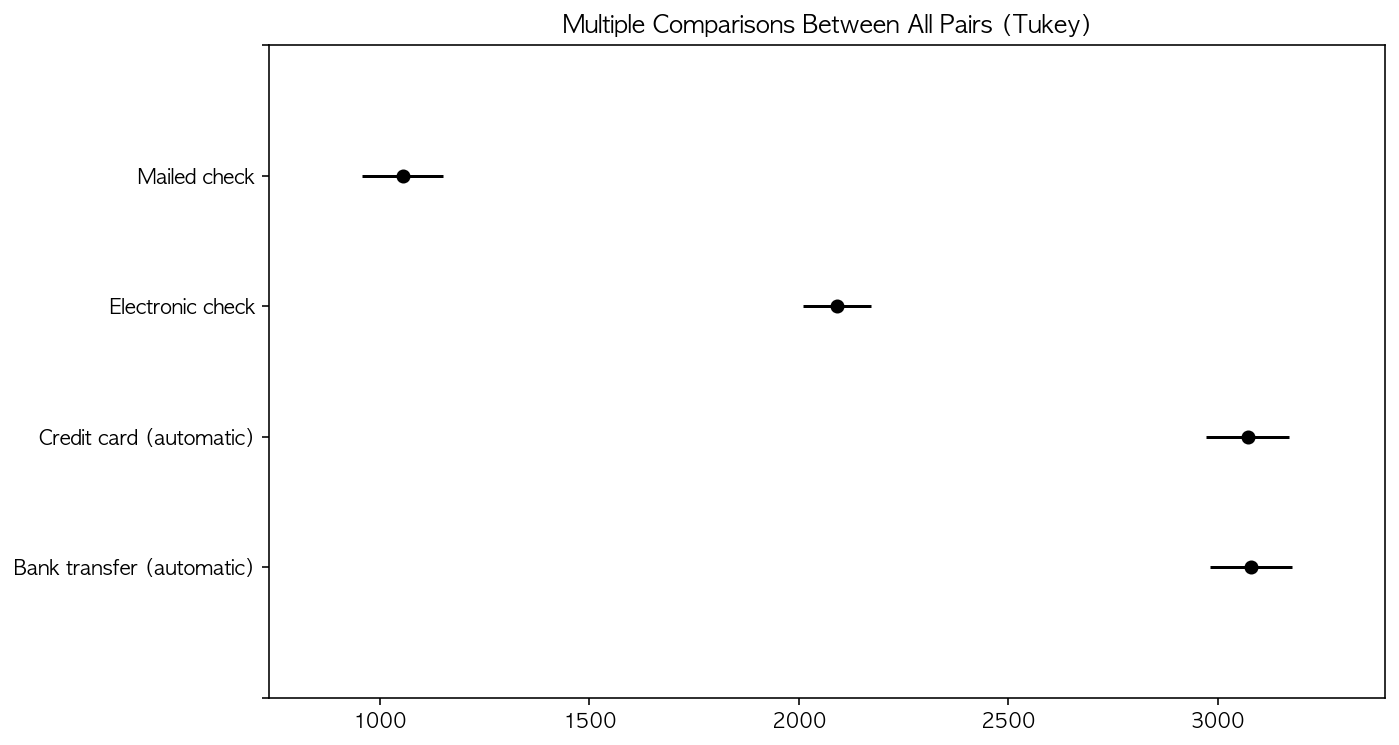

In [244]:
# 사후검정: 그룹간의 평균 차이가 의미가 있는지 확인
from statsmodels.stats.multicomp import pairwise_tukeyhsd

posthoc = pairwise_tukeyhsd(df['TotalCharges'], df['PaymentMethod'])
print(posthoc)
# reject=True: 유의미한 차이가 있다

posthoc.plot_simultaneous()
plt.show()

- Credit card와 Bank transfer사이는 차이가 유의미 하지 않고 나머지는 다 유의미한 차이를 보임
- 결론
    - 지불방법에 따른 총 결제금액 차이는 통계적으로 유의미하다
    - 신용카드와 자동 계좌이체가 가장 높다